# K Nearest Neighbors Classifier

## Introduction

Nearest neighbour is type of instance-based classifier, which trains itself, based on the training
data and predicts the class label of the unknown or target data points. Considering a point which
needs to be classified, the kNN (Nearest neighbour classifier) tries to find k nearest neighbour to
the target data point. It takes the class labels of the nearest neighbour and assigns the label of
target data point accordingly.

In this notebook we are using customer churn data from the telecom industry. 

To find the nearest neighbours the distance between centroid to other data points is calculated. The Minkowski Distance is a generalized form

$\left(\sum_{i=1}^n |x_i-y_i|^p\right)^{1/p}$

Where n is the number of attributes, $𝑥i$ and $𝑦i$ are component of data objects x and y. where p
is degree of distance. 

Based on value of p, the distance measures metric gets changed. For `p = 1`,
the distance is known as City-block metric. Whereas `p = 2`, Euclidean distance. For `𝑟 = ∞`, supermum
distance corresponds to maximum difference between any dimensions

In [2]:
import warnings
warnings.filterwarnings('ignore', module='sklearn')
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (12,6)
import numpy as np
from sklearn.metrics import confusion_matrix, roc_auc_score ,roc_curve,auc
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV

In [3]:
from __future__ import print_function
import os
data_path = ['Machine_Learning/data']

### Data Exploration

In [4]:
import pandas as pd
# Import the data using the file path
filepath = os.sep.join(data_path + ['Orange_Telecom_Churn_Data.csv'])
data = pd.read_csv(filepath)

In [5]:
data.head().T

,0,1,2,3,4
state,KS,OH,NJ,OH,OK
account_length,128,107,137,84,75
area_code,415,415,415,408,415
phone_number,382-4657,371-7191,358-1921,375-9999,330-6626
intl_plan,no,no,no,yes,yes
voice_mail_plan,yes,yes,no,no,no
number_vmail_messages,25,26,0,0,0
total_day_minutes,265.1,161.6,243.4,299.4,166.7
total_day_calls,110,123,114,71,113
total_day_charge,45.07,27.47,41.38,50.9,28.34


In [6]:
# Check columns data type 
data.dtypes.value_counts()

float64    8
int64      8
object     4
bool       1
dtype: int64

There are 4 features with data type `object` Let us verify if we should keep these features for further modeling or we should drop them out. 

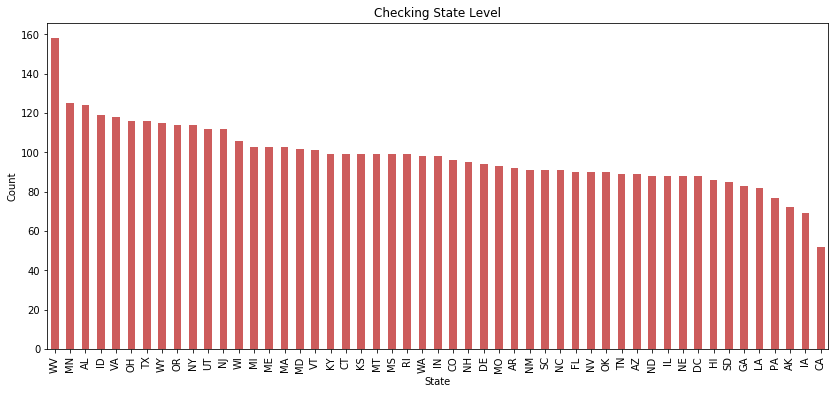

In [7]:
data.state.value_counts().plot(kind = 'bar', figsize = [14,6], color = 'indianred')
plt.title('Checking State Level')
plt.xlabel('State')
plt.ylabel('Count');

In [8]:
print("State Level: {}".format(len(data.state.value_counts())))
print("Area Code Level: {}".format(len(data.area_code.value_counts())))
print("Phone Number Level: {}".format(len(data.phone_number.value_counts())))

State Level: 51
Area Code Level: 3
Phone Number Level: 5000


* Notice that the data contains a state, area code, and phone number.

There are 51 distinct value in state, 3 in area code and 5000 in phone number. Either we can transform these features into dummy variable or we could drop these features. Tranforming phone number does not make sense as it has 5000 unique values. State and area code could be transformed into dummy variable but it will lead to increase the number of column in dataset. Hence, we will not be using them, so they can be dropped from the data.

In [9]:
# Remove extraneous columns
data.drop(['state', 'area_code', 'phone_number'], axis=1, inplace=True)

In [10]:
data.columns

Index(['account_length', 'intl_plan', 'voice_mail_plan',
       'number_vmail_messages', 'total_day_minutes', 'total_day_calls',
       'total_day_charge', 'total_eve_minutes', 'total_eve_calls',
       'total_eve_charge', 'total_night_minutes', 'total_night_calls',
       'total_night_charge', 'total_intl_minutes', 'total_intl_calls',
       'total_intl_charge', 'number_customer_service_calls', 'churned'],
      dtype='object')

In [11]:
# Checking shape 
data.shape

(5000, 18)

Target feature here is `churned` below we will explore the target, and some of the other features using which we will predict the churned. 

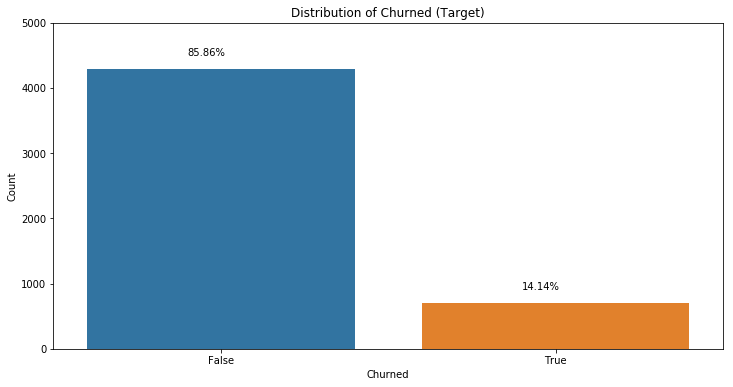

In [12]:
ax = sns.countplot(x = 'churned', data = data)
ax.set_ylim(top=5000)
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(100*p.get_height()/len(data.churned)), (p.get_x()+ 0.3, p.get_height()+200))

plt.title('Distribution of Churned (Target)')
plt.xlabel('Churned')
plt.ylabel('Count');

As can be seen 85.86% entries are with chruned as False and only 14.14%  are churned. This is called a **Unbalanced Class** problem. In classification when the target unequal difference for different classes. This problem could be hadled using different procedures such as cross validation, class balancing using over sampling, under sampling, mixed sampling.

Let us plot few other features and see how is distribution, correlation.

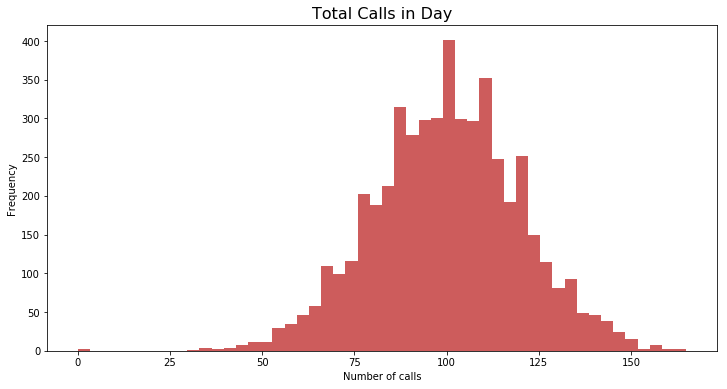

In [13]:
data.total_day_calls.plot(kind = 'hist', bins = 50, color = 'indianred')
plt.title('Total Calls in Day', fontsize = 16)
plt.xlabel('Number of calls');

Scatter plots are the best way to check relation between different features and here as `chruned` as target below we are checking features having hue as churned or not. 

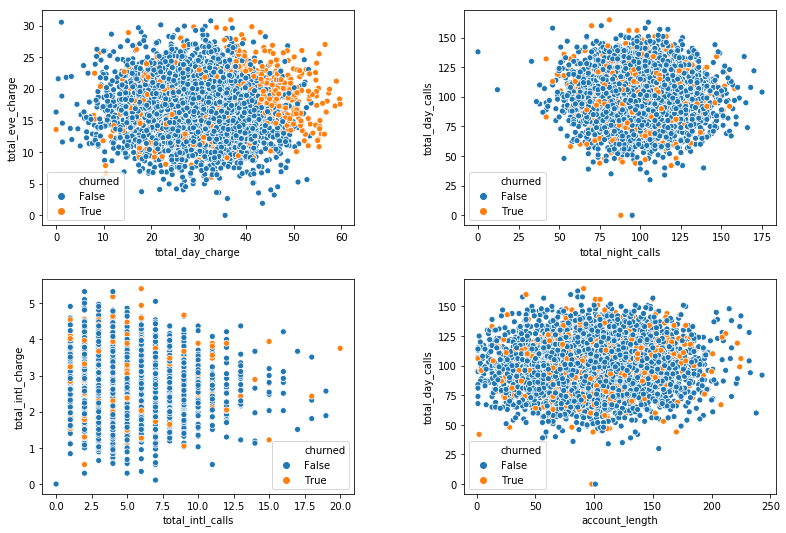

In [14]:
# Subplot 
plt.figure(figsize=(12,8))

plt.subplot(221)
sns.scatterplot(x='total_day_charge', y= 'total_eve_charge', data = data, hue = 'churned' )

plt.subplot(222)
sns.scatterplot(x='total_night_calls', y= 'total_day_calls', data = data, hue = 'churned' )

plt.subplot(223)
sns.scatterplot(x='total_intl_calls', y= 'total_intl_charge', data = data, hue = 'churned' )

plt.subplot(224)
sns.scatterplot(x='account_length', y= 'total_day_calls', data = data, hue = 'churned' )


plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35);


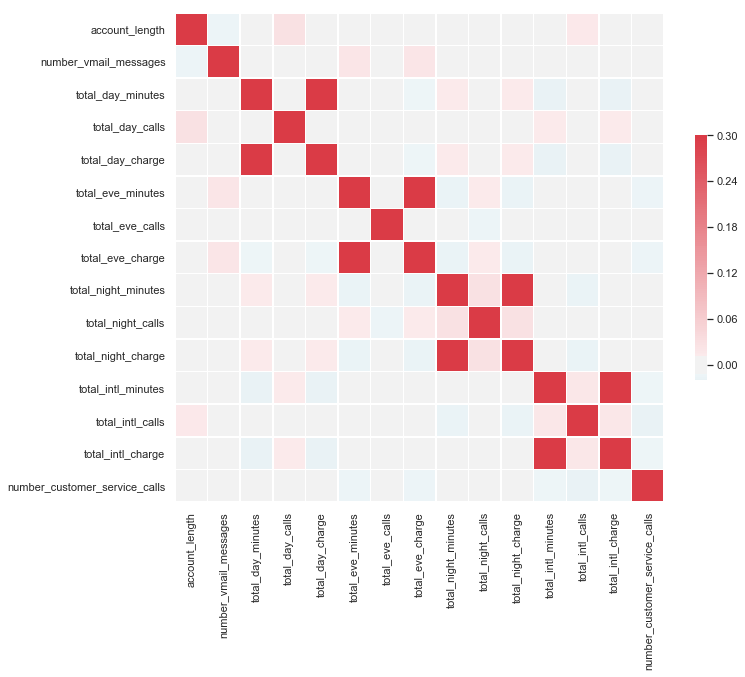

In [15]:
sns.set(style='white')

# Compute the correlation matrix
corr = data.loc[:,[i for i in list(data.columns) if i not in ['churned']]].corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

Notice that some of the columns are categorical data and some are floats. These features will need to be numerically encoded.

Further, We need to scale the data as K-nearest neighbors requires scaled data. 

In [16]:
lb = LabelBinarizer()
for col in ['intl_plan', 'voice_mail_plan', 'churned']:
    data[col] = lb.fit_transform(data[col])

In [17]:
# Mute the sklearn warning
msc = MinMaxScaler()
data = pd.DataFrame(msc.fit_transform(data),  # this is an np.array, not a dataframe.
                    columns=data.columns)

### Model & Evaluation

We should seprate the target `churned` and other features. All the features except `chruned` will be used to predict the target hence will store them in `X_data` and `churned` to `y_data`

After that will just train the knn with 3 number of neighbors and no other parameters. 

In [18]:
# Get a list of all the columns that don't contain the label
x_cols = [x for x in data.columns if x != 'churned']

# Split the data into two dataframes
X_data = data[x_cols]
y_data = data['churned']

In [19]:
# Train the KNN model and fit on training set
knn = KNeighborsClassifier(n_neighbors=3)
knn = knn.fit(X_data, y_data)
y_pred = knn.predict(X_data)

Below function is to calculate accuracy using the actual and predicted labels.

In [20]:
# Function to calculate the % of values that were correctly predicted
def accuracy(real, predict):
    return sum(y_data == y_pred) / float(real.shape[0])

In [21]:
print(accuracy(y_data, y_pred))

0.9422


In [22]:
print(roc_auc_score(y_data, knn.predict_proba(X_data)[::,1]))

0.9775442803339933


Without any cross validation the KNN classifier gives an accuracy of 94% and roc auc score of .97 Since we passed all the data to the model the model is now overfit. To overcome this cross validtion is applied.

In [23]:
# Create trainset and testset 
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.30, random_state=42)

As this is an example of unballanced class problem, `Stratified K fold` is used. Stratified K-Folds cross-validator
Provides train/test indices to split data in train/test sets.

This cross-validation object is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class.

In [24]:
# Run the model on 5 StratifiedKFold and check ROC AUC score
kf = StratifiedKFold(n_splits=5,shuffle=False,random_state=121)
pred_test_full =0
cv_score =[]
i=1
for train_index,test_index in kf.split(X_data,y_data):
    print('{} of KFold {}'.format(i,kf.n_splits))
    xtr,xvl = X_data.loc[train_index],X_data.loc[test_index]
    ytr,yvl = y_data.loc[train_index],y_data.loc[test_index]
    
    #model
    knn = KNeighborsClassifier()
    knn.fit(xtr,ytr)
    score = roc_auc_score(yvl,knn.predict_proba(xvl)[::,1])
    print('ROC AUC score:',score)
    cv_score.append(score)    
    

1 of KFold 5
ROC AUC score: 0.8352448802243029
1 of KFold 5
ROC AUC score: 0.8531743429142961
1 of KFold 5
ROC AUC score: 0.8590064316911468
1 of KFold 5
ROC AUC score: 0.8699267635437847
1 of KFold 5
ROC AUC score: 0.8596810990428012


In [25]:
print("Average CV ROC AUC score: {}".format(np.mean(cv_score)))

Average CV ROC AUC score: 0.8554067034832663


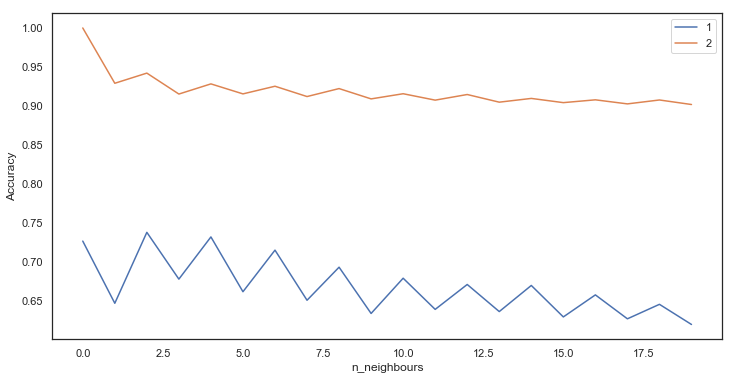

In [26]:
# Check model performance with different number of n_neighbours
for p in [1,2]:
    if p == 1:
        accuracies_1 = [] 
        number = []
        for i in range(1,21):
            knn = KNeighborsClassifier(n_neighbors=i, weights='uniform', p = p)
            knn = knn.fit(X_train, y_train)
            y_pred = knn.predict(X_test)
            acc = roc_auc_score(y_test, y_pred)
            accuracies_1.append(acc)
            number.append(i)
    else:
        accuracies_2 = [] 
        for i in range(1,21):
            knn = KNeighborsClassifier(n_neighbors=i, weights='uniform', p = p)
            knn = knn.fit(X_data, y_data)
            y_pred = knn.predict(X_data)
            acc = accuracy(y_data, y_pred)
            accuracies_2.append(acc)
result1 = pd.DataFrame({'NumberOfk':number,'Accuracy_1':accuracies_1})
result2 = pd.DataFrame({'NumberOfk':number,'Accuracy_2':accuracies_2})

final = pd.merge(result1, result2)
final.Accuracy_1.plot(label='1')
final.Accuracy_2.plot(label='2')
plt.legend()
plt.xlabel('n_neighbours')
plt.ylabel('Accuracy');

##### Learning Curve 

A learning curve is the plot of the training/cross-validation error versus the sample size. The learning curve can be used to detect whether the model has the high bias or high variance. If the model suffers from high bias problem, as the sample size increases, training error will increase and the cross validation error will decrease and at last they will be very close to each other but still at a high error rate for both training and classification error. And increasing the sample size will not help much for high bias problem.

If the model suffers from high variance, as the keep increasing the sample size, the training error will keep increasing and cross-validation error will keep decreasing and they will end up at a low training and cross-validation error rate. So more samples will help to improve the model prediction performance if the model suffer from high variance.

In [27]:
def plot_learning_curve(model, x, y, ):
    # Learning curve 
    train_sizes, train_scores, valid_scores = learning_curve(model, x, y, scoring = 'accuracy', n_jobs = -1, train_sizes=np.linspace(0.01, 1.0, 20))
    # Create means and standard deviations of training set scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    # Create means and standard deviations of test set scores
    test_mean = np.mean(valid_scores, axis=1)
    test_std = np.std(valid_scores, axis=1)
    # Draw lines
    plt.plot(train_sizes, train_mean, '--', color="green",  label="Training score")
    plt.plot(train_sizes, test_mean, color="brown", label="Cross-validation score")
    # Draw bands
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")
    # Create plot
    plt.title("Learning Curve", fontsize = 16)
    plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

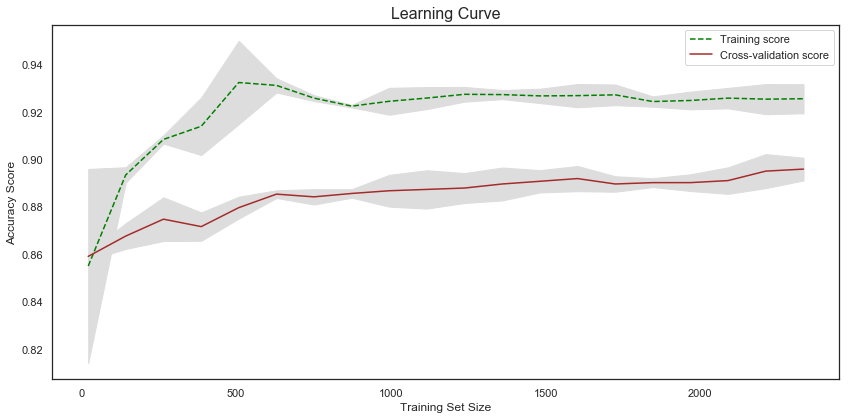

In [28]:
knn = KNeighborsClassifier()
plot_learning_curve(knn, X_train,y_train)

### Hyperparameter optimization

Tuning is the problem of choosing a set of optimal hyperparameters for a learning algorithm. A hyperparameter is a parameter whose value is used to control the learning process.

In [29]:
# Grid search for KNNclassifier tuning 
classifier = KNeighborsClassifier()
parameters = [{'metric':['minkowski','euclidean','manhattan'], 'weights': ['uniform','distance'], 'n_neighbors':  np.arange(1,10)}]
grid_search = GridSearchCV(estimator = classifier, param_grid = parameters, scoring = 'accuracy', cv = 5, n_jobs = -1)
grid_search = grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

In [30]:
# Check hyperparameters
print(best_parameters )

{'metric': 'manhattan', 'n_neighbors': 8, 'weights': 'distance'}


In [31]:
# Run the model on 5 StratifiedKFold and check ROC AUC score
kf = StratifiedKFold(n_splits=5,shuffle=False,random_state=121)
pred_test_full =0
cv_score =[]
i=1
for train_index,test_index in kf.split(X_data,y_data):
    print('{} of KFold {}'.format(i,kf.n_splits))
    xtr,xvl = X_data.loc[train_index],X_data.loc[test_index]
    ytr,yvl = y_data.loc[train_index],y_data.loc[test_index]
    
    #model
    knn = KNeighborsClassifier(n_neighbors=8, weights='distance', metric = 'manhattan')
    knn.fit(xtr,ytr)
    score = roc_auc_score(yvl,knn.predict_proba(xvl)[::,1])
    print('ROC AUC score:',score)
    cv_score.append(score)    


1 of KFold 5
ROC AUC score: 0.859253307973569
1 of KFold 5
ROC AUC score: 0.8662381740969683
1 of KFold 5
ROC AUC score: 0.8774799990092388
1 of KFold 5
ROC AUC score: 0.8879631007290583
1 of KFold 5
ROC AUC score: 0.8972705781216419


In [32]:
print("Average CV ROC AUC score: {}".format(np.mean(cv_score)))

Average CV ROC AUC score: 0.8776410319860952


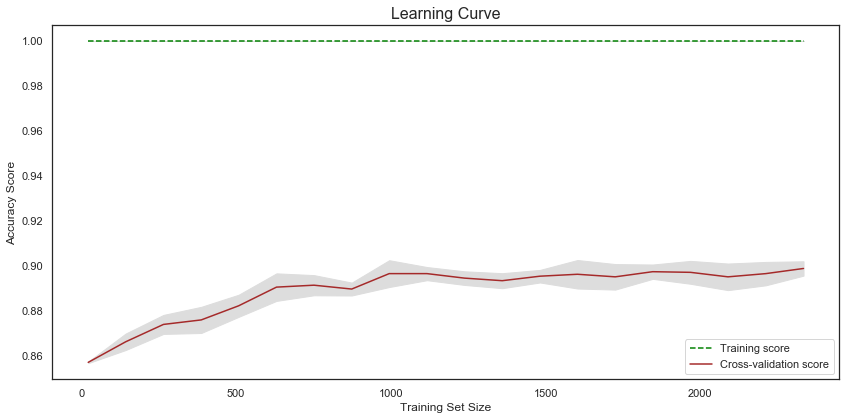

In [33]:
knn = KNeighborsClassifier(n_neighbors=8, weights='distance', metric = 'manhattan')
plot_learning_curve(knn, X_train,y_train)

By Tuning the model and using 5 Stratified fold the average ROC AUC score was increased from 0.855 to 0.877 on the cross validation set. 